# Lab4a NERC using a bidirectional Long-Short-Term-Memory (biLSTM) and Conditional Random Fields (CRF)

Copyright: Vrije Universiteit Amsterdam, Faculty of Humanities, CLTL

Combining a bidirectional LSTM model and a CRF model. The so called LSTM-CRF approach to named entity recognition.

We are going to use the implementation provided by the keras-contrib package, that contains useful extensions to the official keras package.

Credits:
* https://www.depends-on-the-definition.com/sequence-tagging-lstm-crf/


### Preparations


We are going to use the *keras* package to train a LSTM model on our data:

https://keras.io

You need to install *keras* on your local machine. To know which version you may already have run:

> pip list | grep tensorflow

To install *keras* run:

> pip install keras

As a backend, we also need tensorflow (you may need to install an older version of tensorflow, such as 2.1.0):

https://www.tensorflow.org

> pip install tensorflow (or: pip install tensorflow==2.1.0)

We further need an extension to keras:

https://github.com/keras-team/keras-contrib

> pip install git+https://www.github.com/keras-team/keras-contrib.git


For evaluation of sequence tagging, we are going to use a pakage *seqeval* which was tested on CoNLL tasks:

https://github.com/chakki-works/seqeval

> pip install seqeval[cpu]


In [1]:
import pandas as pd
import numpy as np

data = pd.read_csv("ner_dataset.csv", encoding="latin1")
data = data.fillna(method="ffill")
data = data.fillna(method="ffill")

data.tail(10)

,Sentence #,Word,POS,Tag
1048565,Sentence: 47958,impact,NN,O
1048566,Sentence: 47958,.,.,O
1048567,Sentence: 47959,Indian,JJ,B-gpe
1048568,Sentence: 47959,forces,NNS,O
1048569,Sentence: 47959,said,VBD,O
1048570,Sentence: 47959,they,PRP,O
1048571,Sentence: 47959,responded,VBD,O
1048572,Sentence: 47959,to,TO,O
1048573,Sentence: 47959,the,DT,O
1048574,Sentence: 47959,attack,NN,O


In [2]:
words = list(set(data["Word"].values))
words.append("ENDPAD")
n_words = len(words); n_words

35179

In [3]:
tags = list(set(data["Tag"].values))
n_tags = len(tags); n_tags

17

So we have 47959 sentences containing 35178 different words with 17 different tags. Note again that we want to capture strong sequence dependencies within sentence. We use the SentenceGetter class from the previous notebook to retrieve sentences with their labels.

In [4]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [5]:
getter = SentenceGetter(data)

In [6]:
sent = getter.get_next()
print(sent)

[('Thousands', 'NNS', 'O'), ('of', 'IN', 'O'), ('demonstrators', 'NNS', 'O'), ('have', 'VBP', 'O'), ('marched', 'VBN', 'O'), ('through', 'IN', 'O'), ('London', 'NNP', 'B-geo'), ('to', 'TO', 'O'), ('protest', 'VB', 'O'), ('the', 'DT', 'O'), ('war', 'NN', 'O'), ('in', 'IN', 'O'), ('Iraq', 'NNP', 'B-geo'), ('and', 'CC', 'O'), ('demand', 'VB', 'O'), ('the', 'DT', 'O'), ('withdrawal', 'NN', 'O'), ('of', 'IN', 'O'), ('British', 'JJ', 'B-gpe'), ('troops', 'NNS', 'O'), ('from', 'IN', 'O'), ('that', 'DT', 'O'), ('country', 'NN', 'O'), ('.', '.', 'O')]


In [7]:
sentences = getter.sentences
print(len(sentences))

47959


### Prepare the data

Now we introduce dictionaries of words and tags.

In [8]:
word2idx = {w: i + 1 for i, w in enumerate(words)}
idx2word = {i: w 
            for i, w in enumerate(words, 1)}


tag2idx = {t: i for i, t in enumerate(tags)}

In [9]:
word2idx["Obama"]

17482

In [10]:
tag2idx["B-geo"]

12

Now we map the senctences to a sequence of numbers and then pad the sequence. Padding is required by *tensorflow* to make the vector representation the same size. We define a maximum size of a sentence of 75 tokens and extend shorter sentence with zero values (padding).

Note that we increased the index of the words by one to use zero as a padding value. This is done because we want to use the mask_zeor parameter of the embedding layer to ignore inputs with value zero.

In [11]:
max_len = 75

In [12]:
from keras.preprocessing.sequence import pad_sequences
X = [[word2idx[w[0]] for w in s] for s in sentences]
y = [[tag2idx[w[2]] for w in s] for s in sentences]

Using TensorFlow backend.


We need to apply the pad_sequences function to both the data and the tags.

In [13]:
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=n_words-1)
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])

The first data item now looks as follows:

In [14]:
print(X[0])

[ 8036 23117 32729 20589  2933 33575  3776 24727 35061  5468 10911 16163
 13286 10524 28525  5468 33548 23117  7670 31062 27875  2438  3033 29874
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178]


It is a vector with 75 elements represented through numerical values.

In [15]:
X[0].shape

(75,)

In [16]:
print(word2idx.get("Obama"))

17482


The 75 tags that go with the first data item look as follows:

In [17]:
print(y[0])

[13 13 13 13 13 13 12 13 13 13 13 13 12 13 13 13 13 13 10 13 13 13 13 13
 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13
 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13
 13 13 13]


In [18]:
y[0].shape

(75,)

In [19]:
from tensorflow.keras.utils import to_categorical
y = [to_categorical(i, num_classes=n_tags) for i in y]

For training the biLSTM network we also need to change the labels y to categorial.

In [20]:
print(y[0])

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [21]:
y[0].shape

(75, 17)

We split in train and test set.

In [22]:
from sklearn.model_selection import train_test_split

In [23]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.1)

In [24]:
print('Number of training instances:', len(X_tr))
print('Number of test instances:', len(X_te))

Number of training instances: 43163
Number of test instances: 4796


### Setup the CRF-LSTM

Now we can fit a LSTM-CRF network with an embedding layer.

In [25]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras_contrib.layers import CRF

In [26]:
input = Input(shape=(max_len,))
model = Embedding(input_dim=n_words + 1, output_dim=20,
                  input_length=max_len)(input)  # 20-dim embedding

In [27]:
model = Bidirectional(LSTM(units=50, return_sequences=True,
                           recurrent_dropout=0.1))(model)  # variational biLSTM

In [28]:
model = TimeDistributed(Dense(50, activation="relu"))(model)  # a dense layer as suggested by neuralNer

In [29]:
crf = CRF(n_tags)  # CRF layer assigning our defined tag set

In [30]:
out = crf(model)  # output
# If you have the following error: Keras.backend doesnt have slice operation. 
# You can go to the location where crf.py file is stored locally on your machine 
# (this you can find mentioned in the error dialogue, 
# i.e. /home//anaconda3/lib/python3.8/site-packages/keras_contrib/layers/crf.py) 
# and do the following:

# add the line --> import tensrflow as tf
# replace K.slice by tf.slice

# restart the jupyter notebook session.

In [31]:
model = Model(input, out)

In [32]:
model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])

/Users/iliamarkov/Documents/work/lib/python3.7/site-packages/keras_contrib/layers/crf.py:347: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/Users/iliamarkov/Documents/work/lib/python3.7/site-packages/keras_contrib/layers/crf.py:354: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


In [33]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 75)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 75, 20)            703600    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 75, 100)           28400     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 75, 50)            5050      
_________________________________________________________________
crf_1 (CRF)                  (None, 75, 17)            1190      
Total params: 738,240
Trainable params: 738,240
Non-trainable params: 0
_________________________________________________________________


We are going to fit the model in a number of *epochs* on the training set *X_tr*, which is split into training (90%) and validation (10%).

In [34]:
history = model.fit(X_tr, np.array(y_tr), batch_size=32, epochs=5,
                    validation_split=0.1, verbose=1)

/Users/iliamarkov/Documents/work/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 38846 samples, validate on 4317 samples
Epoch 1/5
38846/38846 [==============================] - 83s 2ms/step - loss: 0.1106 - crf_viterbi_accuracy: 0.9686 - val_loss: 0.0321 - val_crf_viterbi_accuracy: 0.9837
Epoch 2/5
38846/38846 [==============================] - 86s 2ms/step - loss: 0.0130 - crf_viterbi_accuracy: 0.9871 - val_loss: 1.7857e-04 - val_crf_viterbi_accuracy: 0.9881
Epoch 3/5
38846/38846 [==============================] - 82s 2ms/step - loss: -0.0135 - crf_viterbi_accuracy: 0.9900 - val_loss: -0.0208 - val_crf_viterbi_accuracy: 0.9894
Epoch 4/5
38846/38846 [==============================] - 85s 2ms/step - loss: -0.0338 - crf_viterbi_accuracy: 0.9911 - val_loss: -0.0391 - val_crf_viterbi_accuracy: 0.9897
Epoch 5/5
38846/38846 [==============================] - 83s 2ms/step - loss: -0.0520 - crf_viterbi_accuracy: 0.9917 - val_loss: -0.0564 - val_crf_viterbi_accuracy: 0.9900


### Some explanations:
ETA = estimated time of arrival
loss = loss during training tested on training data
crf_viterbi_accuracy = accuracy during training of the CRF to make the right sequence prediction in a Viterbi model of all possible sequences
val_loss = loss on the validation set (4317 instances) after training during the Epoch
val_crf_viterbi_accuracy = accuracy on the validation set (4317 instances)

The validation results are most important. We see that the loss decreases and the accuracy increases.

Note: if your validation loss/accuracy starts increasing while your training loss/accuracy is still decreasing, this is an indicator of overfitting.

Let's visualise the learning.

In [35]:
hist = pd.DataFrame(history.history)

In [36]:
hist.head

<bound method NDFrame.head of    val_loss  val_crf_viterbi_accuracy      loss  crf_viterbi_accuracy
0  0.032076                  0.983708  0.110579              0.968615
1  0.000179                  0.988099  0.012984              0.987139
2 -0.020775                  0.989382 -0.013457              0.989960
3 -0.039142                  0.989720 -0.033765              0.991067
4 -0.056354                  0.990035 -0.052032              0.991724>

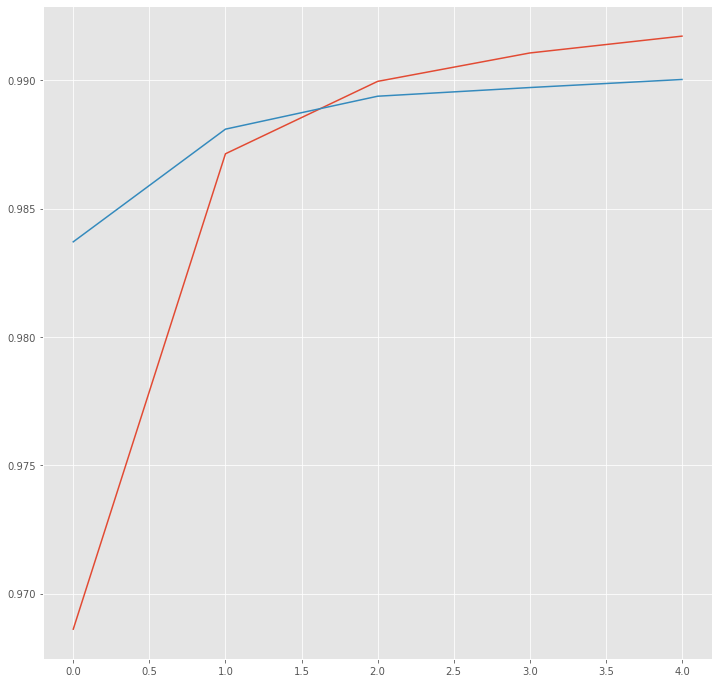

In [37]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure(figsize=(12,12))
plt.plot(hist["crf_viterbi_accuracy"]) #blue line
plt.plot(hist["val_crf_viterbi_accuracy"]) #red line
plt.show()

The graph shows that the accuracy during training (blue) starts higher but does not grow as steep and flattens earlier than the accuracy on the validation set. This is a good sign.

## Evaluation on the hold out test set

For evaluation, we are going to use the *seqeval* package which is specifically designed for sequence annotations. 
In our case, it will return scores for he complete phrases instead of the IOB tags for the tokens. It also ignores the "O" tag which is dominant.

In [38]:
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report

In [39]:
test_pred = model.predict(X_te, verbose=1)

4796/4796 [==============================] - 3s 556us/step


Note that running a trained model on a test set is much faster and requires less cpu. 

We define a little function to get a sequence of tags from the gold data *y_te* and the system data *test_pred*.

In [40]:
idx2tag = {i: w for w, i in tag2idx.items()}

def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("PAD", "O"))
        out.append(out_i)
    return out
    
pred_labels = pred2label(test_pred)  ### system data
test_labels = pred2label(y_te)  ### gold data

We use the function *precision_score*, *recall_score*, and *f1_score* from the *seqeval* package to get the overall sequence annotation results for the total set.

In [41]:
print("precision-score: {:.1%}".format(precision_score(test_labels, pred_labels)))
print("recall-score: {:.1%}".format(recall_score(test_labels, pred_labels)))
print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))

precision-score: 83.1%
recall-score: 81.3%
F1-score: 82.2%


This looks pretty good and it did require any feature engineering, as we did before for the CRF notebook in which we defined specific features. Remember that for the CRF with feature engineering and parameter optimalization, we obtained the following result:

* Before parameterization:
```
precision-score: 84.6%
recall-score: 83.2%
F1-score: 83.9%
```

* After parameterization:
```
precision-score: 76.5%
recall-score: 72.8%
F1-score: 74.6%
```

We can further improve the classifier by using word embeddings instead of token representations but also by adding character embeddings to the word embeddings. Character embedding capture many properties such as word shape, prefixes and suffixes, among others in an intituive way without define explicit features for these. Below is some literature on this approach.

References and further reading:

* Huang et. al: Bidirectional LSTM-CRF Models for Sequence Tagging [https://arxiv.org/pdf/1508.01991v1.pdf]
* Ma et al.: End-to-end Sequence Labeling via Bi-directional LSTM-CNNs-CRF [https://arxiv.org/pdf/1603.01354.pdf]


In [42]:
print(classification_report(test_labels, pred_labels))

/Users/iliamarkov/Documents/work/lib/python3.7/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         art       0.00      0.00      0.00        30
         eve       0.00      0.00      0.00        28
         geo       0.85      0.89      0.87      3748
         gpe       0.97      0.92      0.94      1665
         nat       0.00      0.00      0.00        22
         org       0.75      0.64      0.69      2000
         per       0.72      0.75      0.74      1663
         tim       0.86      0.84      0.85      2078

   micro avg       0.83      0.81      0.82     11234
   macro avg       0.52      0.50      0.51     11234
weighted avg       0.82      0.81      0.82     11234



Finally, we inspect some predictions.

In [43]:
i = 1927
p = model.predict(np.array([X_te[i]]))
p = np.argmax(p, axis=-1)
true = np.argmax(y_te[i], -1)
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, t, pred in zip(X_te[i], true, p[0]):
    if w != 0:
        print("{:15}: {:5} {}".format(words[w-1], tags[t], tags[pred]))

Word           ||True ||Pred
The            : O     O
Lion           : O     O
replied        : O     O
,              : O     O
"              : O     O
I              : O     O
have           : O     O
no             : O     O
objection      : O     O
,              : O     O
but            : O     O
you            : O     O
must           : O     O
excuse         : O     O
me             : O     O
for            : O     O
requiring      : O     O
you            : O     O
to             : O     O
find           : O     O
surety         : O     O
for            : O     O
your           : O     O
good           : O     O
faith          : O     O
,              : O     O
for            : O     O
how            : O     O
can            : O     O
I              : O     O
trust          : O     O
anyone         : O     O
as             : O     O
a              : O     O
friend         : O     O
who            : O     O
is             : O     O
able           : O     O
to             : O   

### Applying the model to an external sentence.

If we want to apply the above model to any text, we need to represent it as tokenized sentences and represent each sentence according to the vocabulary and with the right padding.

In [44]:
test_sentence = ["Hawking", "was", "a", "Fellow", "of", "the", "Royal", "Society", ",", "a", "lifetime", "member",
                 "of", "the", "Pontifical", "Academy", "of", "Sciences", ",", "and", "a", "recipient", "of",
                 "the", "Presidential", "Medal", "of", "Freedom", ",", "the", "highest", "civilian", "award",
                 "in", "the", "United", "States", "."]

Now we transform every word to it’s integer index. Note that we mapping unknown words to zero. Normally you would want to add a UNKNOWN token to your vocabulary. Then you cut the vocabulary on which you train the model and replace all uncommon words by the UNKNOWN token. We haven’t done this for simplicity.

In [45]:
x_test_sent = pad_sequences(sequences=[[word2idx.get(w, 0) for w in test_sentence]],
                            padding="post", value=0, maxlen=max_len)

In [46]:
print(x_test_sent)

[[    0 14194 21351 10268 23117  5468  9867 32604  4448 21351 30585 15277
  23117  5468 11310  6266 23117 28655  4448 10524 21351  7248 23117  5468
  30375     0 23117  7330  4448  5468 24028 31182 20139 16163  5468 11404
  32111 29874     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0]]


And now we can predict with the model and see what we got.

In [47]:
p = model.predict(np.array([x_test_sent[0]]))
p = np.argmax(p, axis=-1)
print("{:15}||{}".format("Word", "Prediction"))
print(30 * "=")
for w, pred in zip(test_sentence, p[0]):
    print("{:15}: {:5}".format(w, tags[pred]))

Word           ||Prediction
Hawking        : O    
was            : O    
a              : O    
Fellow         : O    
of             : O    
the            : O    
Royal          : B-org
Society        : I-org
,              : O    
a              : O    
lifetime       : O    
member         : O    
of             : O    
the            : O    
Pontifical     : B-org
Academy        : I-org
of             : I-org
Sciences       : I-org
,              : O    
and            : O    
a              : O    
recipient      : O    
of             : O    
the            : O    
Presidential   : B-org
Medal          : I-org
of             : I-org
Freedom        : I-org
,              : O    
the            : O    
highest        : O    
civilian       : O    
award          : O    
in             : O    
the            : O    
United         : B-geo
States         : I-geo
.              : O    


## End of this notebook